In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### Notebook outline
1. Objectives
    - Predicting phishing websites based on their features 
    - Features have values in [-1, 0, 1]
        - -1: Legitimate
        - 0: Suspicious
        - 1: phishing
        - Decision (result) has value in [-1,1] ~ [Legitimate, phishing] <br/><br/>
        (Detail in [Phishing Websites Features](./Phishing%20Websites%20Features.docx))<br/>
    - Model: Decision Tree
2. Data Exploring (Exploratory Data Analysis) 
    - Check if data is imbalanced 
    - Use charts to visulize the relationship between features and the dependent variable 
    - Heatmap matrix to find the correlation between features 
3. Data processing
4. Data preparation 
    - Split train and test dataset 
5. Data modelling
6. Hyperparameter Tuning
7. Evaluate model
    - Accuracy, Precision, Recall, F1 
    - ROC-AUC
    - Cross validation 
    - Important features
8. Visualization 
9. Conclusions

### 2. Data Exploring<br> 
Data: (example size, features) = (11055, 30)


In [2]:
df = pd.read_csv('data/phishing.csv', sep=";")

In [3]:
df.shape

(11055, 31)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

In [5]:
df.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWindow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

In [6]:
df = df.dropna(axis=0, how='all')
df = df.drop_duplicates()

### 2.1 Check if data is imbalanced

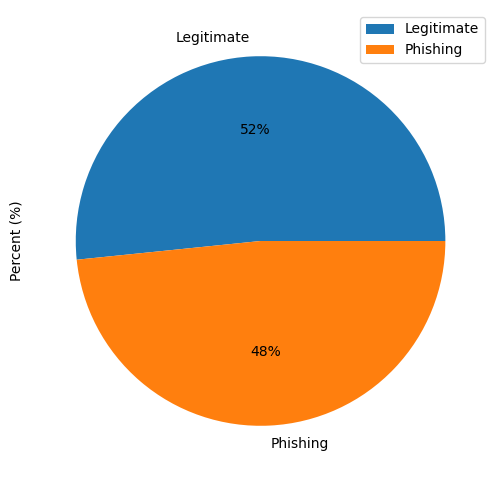

In [7]:
df.Result.value_counts(normalize=True).plot.pie(autopct='%1.f%%', labels=['Legitimate', 'Phishing'], figsize=(6,6)) # normalize=True -> percentage 
plt.ylabel('Percent (%)')
plt.legend()
plt.show()

### 2.2 Use charts to visulize the relationship between features and the dependent variable 

From the charts: SSS_FinalState, Prefix_Suffix, and URL_of_Anchor can be the main features for categorizing the Result.

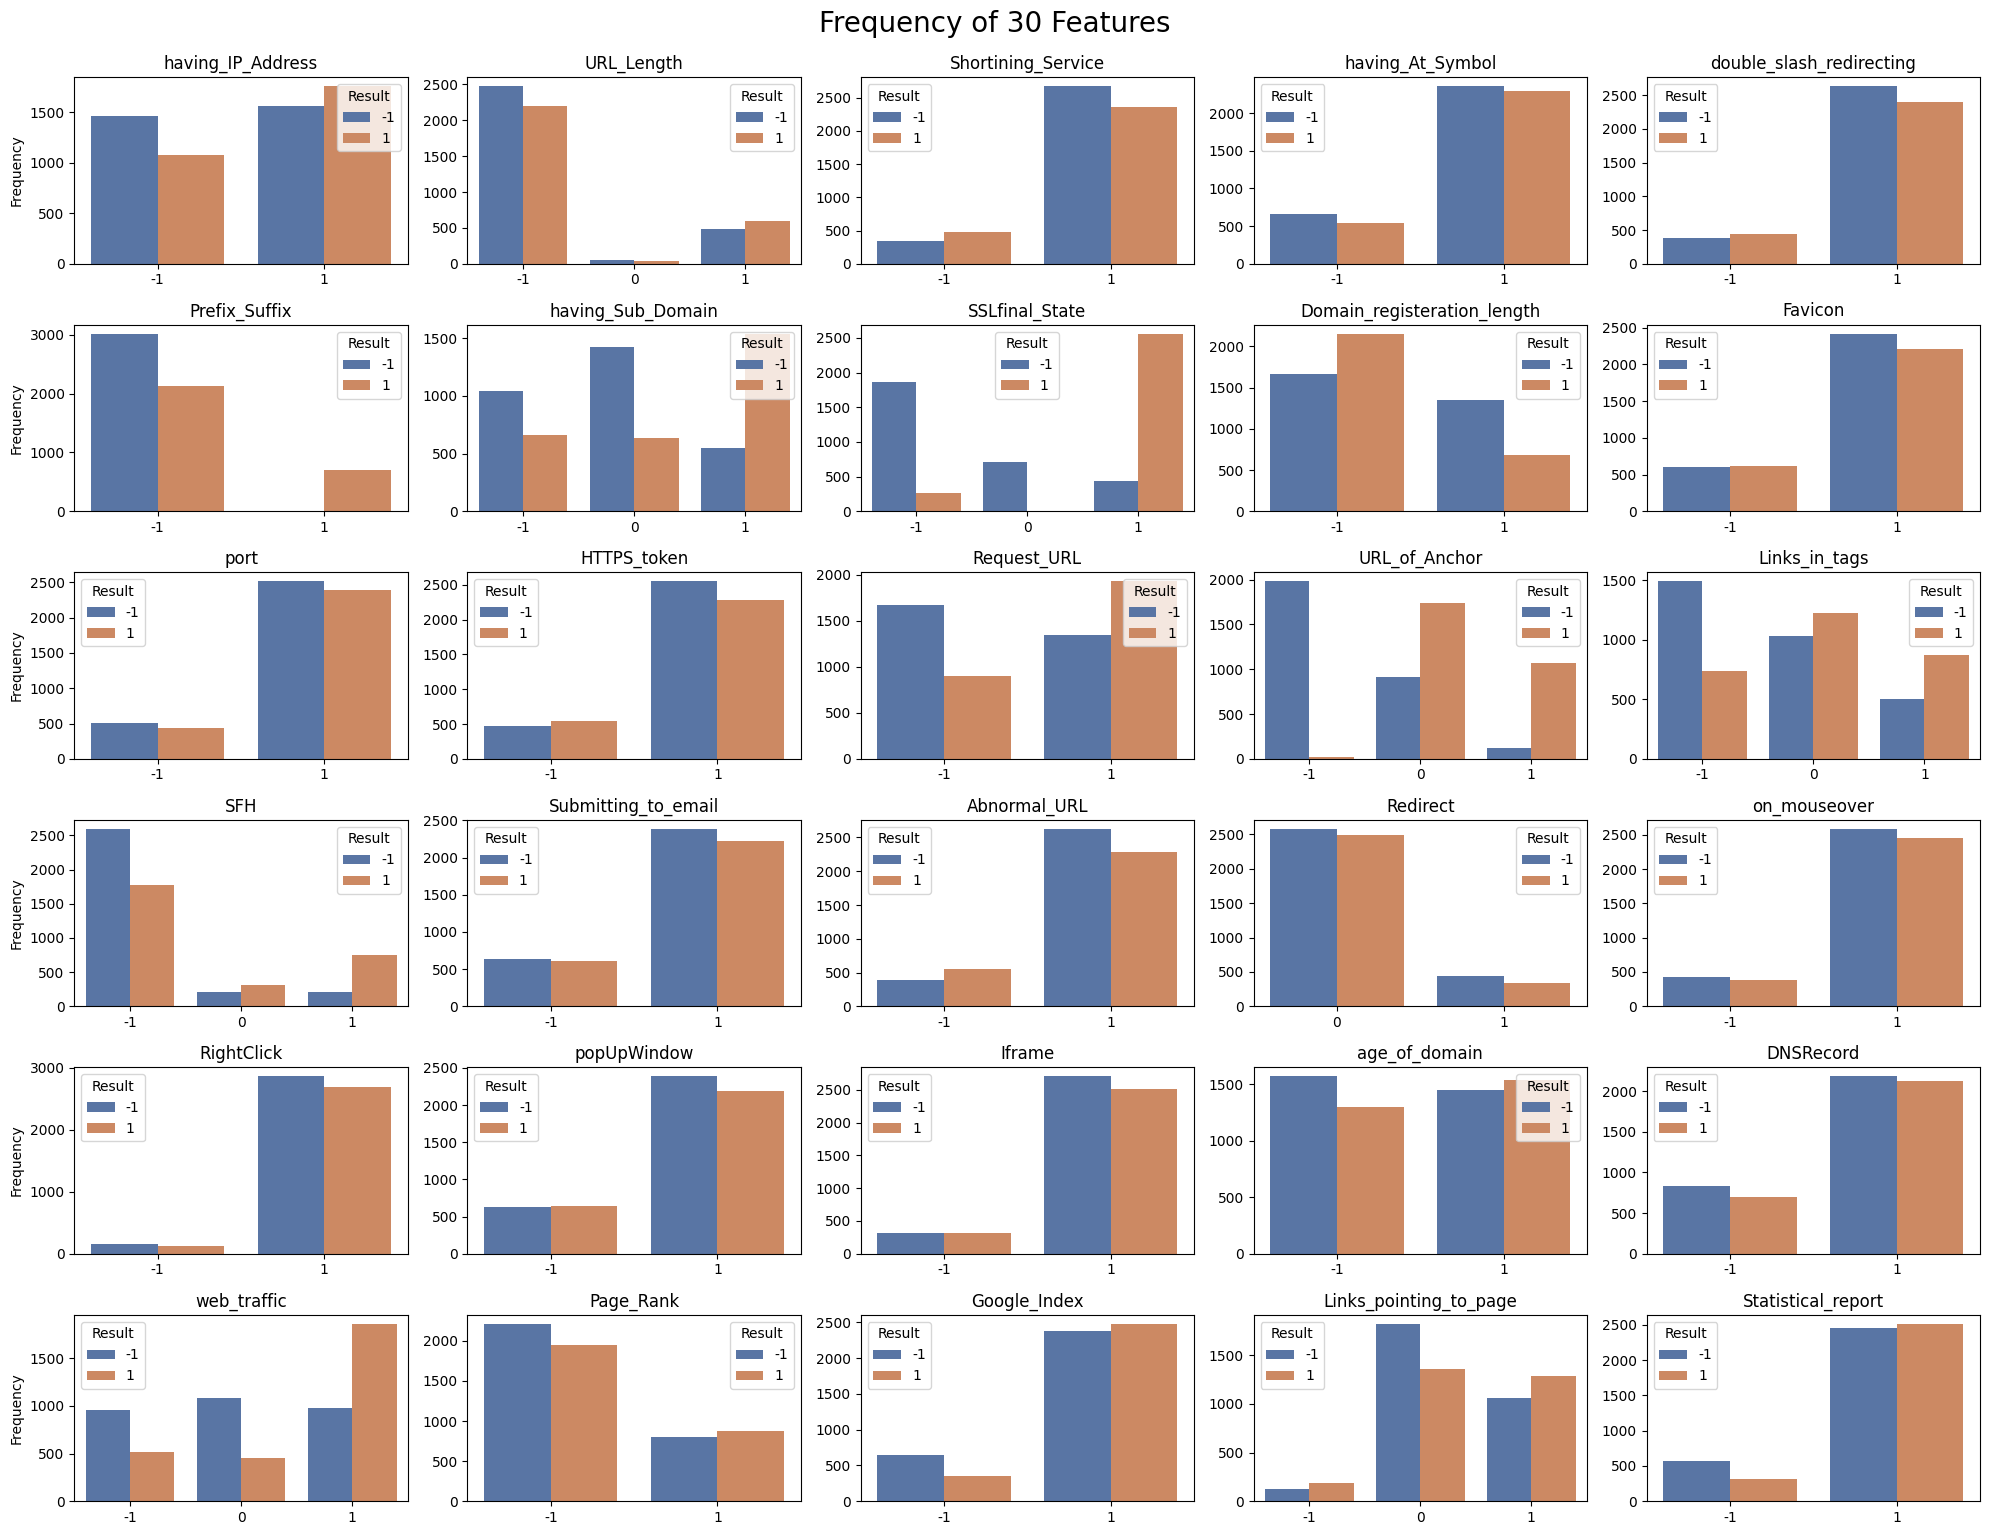

In [8]:
fig, axes = plt.subplots(6, 5, figsize=(20, 15))  # 6 rows x 5 columns grid
axes = axes.flatten()
palette = sns.diverging_palette(240, 10, n=2, center="light")


for i, col in enumerate(df.columns.drop('Result')):
    sns.countplot(x=col, hue='Result', data=df, palette='deep', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency' if i % 5 == 0 else '')

plt.tight_layout()
plt.suptitle('Frequency of 30 Features', fontsize=20, y=1.02)
plt.show()


### 2.3 Heatmap Matrix

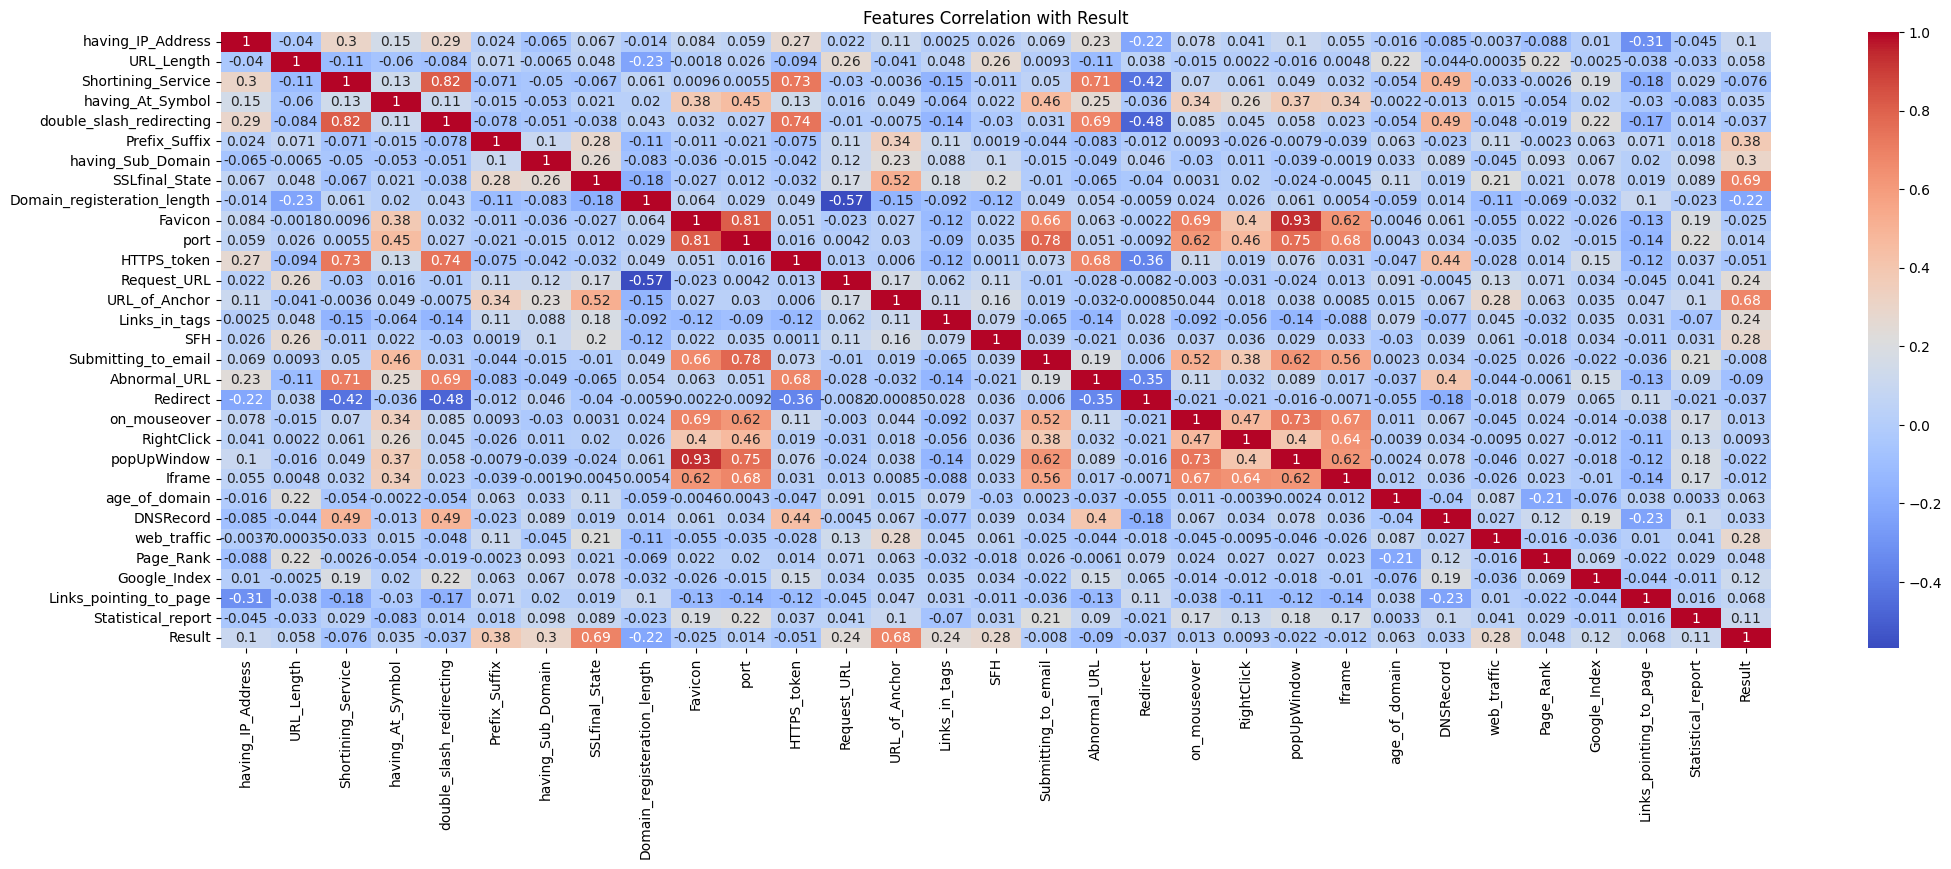

In [9]:
corr = df.corr() 
plt.figure(figsize=(25,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Features Correlation with Result')
plt.show()

### 3. Data Processing

No need to data processing in decision tree if dataset does not have continuous feature 

### 4. Data preparation 

In [10]:
X = df.iloc[:, :-1]
y_true = df.iloc[:, -1]
feature_names = X.columns
class_names = ['Legitimate', 'Phishing'] # order asc -1, 1

stratify: ensure to have the same ratio of Positive/Negative of classes after splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=.2, random_state=42, stratify=y_true)

In [12]:
print(X_train.shape)
print(X_test.shape)

(4679, 30)
(1170, 30)


### 5. Modelling

In [13]:
classifier = tree.DecisionTreeClassifier(max_depth=3) # small dataset -> max_depth: [2, 3, 4, 5]
classifier.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [14]:
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print("Accuracy calculated from the training set = %.3f (SUBJECT TO OVERFITTING)\n" % (accuracy))
print("Confusion matrix:\n",matrix)
print(classification_report(y_test, y_pred, target_names=['no','yes']))
#print(y_pred_proba)

Accuracy calculated from the training set = 0.904 (SUBJECT TO OVERFITTING)

Confusion matrix:
 [[542  62]
 [ 50 516]]
              precision    recall  f1-score   support

          no       0.92      0.90      0.91       604
         yes       0.89      0.91      0.90       566

    accuracy                           0.90      1170
   macro avg       0.90      0.90      0.90      1170
weighted avg       0.90      0.90      0.90      1170



### 6. Tuning hyperparameters of the model using GridSearchCV

In [15]:
pipeline = Pipeline(steps=[
    ('model', classifier)
])
param_grid = {
    'model__max_depth': [2, 3, 4], 
    'model__criterion':['gini','entropy'],
    'model__min_samples_split':[2, 4],
    'model__min_samples_leaf':[5, 10, 13]
}
# n_jobs=-1: core number to run parallel, -1: all
# verbose: detail level of output (0, 1, 2, 3)
grid = GridSearchCV(pipeline,param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', return_train_score=True, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,Pipeline(step...ax_depth=3))])
,param_grid,"{'model__criterion': ['gini', 'entropy'], 'model__max_depth': [2, 3, ...], 'model__min_samples_leaf': [5, 10, ...], 'model__min_samples_split': [2, 4]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'entropy'


**Hyperparameters that model gets the highest score on the train set:**


In [16]:
print("Hyperparameters that model gets the highest score on the train set:")
print(grid.best_params_)


Hyperparameters that model gets the highest score on the train set:
{'model__criterion': 'entropy', 'model__max_depth': 4, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}


### 7. Evaluation

- We have quite stable accurary scores on both the train and test dataset -> not overfitting and underfitting
- Accuracy is higher than baseline (52%) -> the model is acceptable  

### 7.1 Accuracy, F1, Recall, Elastic

In [17]:
treemodel = grid.best_estimator_.steps[-1][1]

y_train_pred = treemodel.predict(X_train)

y_pred = treemodel.predict(X_test)
y_pred_proba = treemodel.predict_proba(X_test)[:, ]

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy calculated from the training set = %.3f" % (accuracy_train))
print("Accuracy calculated from the testing set = %.3f\n" % (accuracy))
print("Confusion matrix:\n",cf_matrix)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

Accuracy calculated from the training set = 0.917
Accuracy calculated from the testing set = 0.904

Confusion matrix:
 [[542  62]
 [ 50 516]]
              precision    recall  f1-score   support

          no       0.92      0.90      0.91       604
         yes       0.89      0.91      0.90       566

    accuracy                           0.90      1170
   macro avg       0.90      0.90      0.90      1170
weighted avg       0.90      0.90      0.90      1170



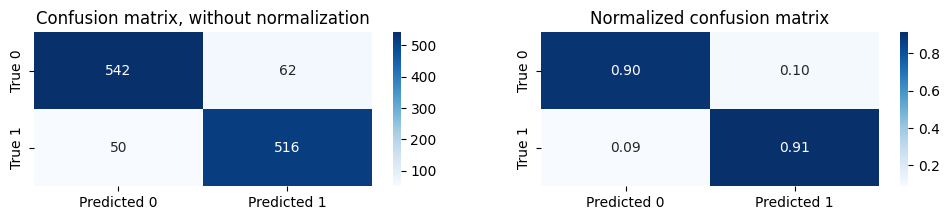

In [18]:

def plot_confusion_matrix(cm, classes, cmap='Blues'):
    _, ax = plt.subplots(1,2, figsize=(12,2))

    # Plot non-normalized confusion matrix
    fmt_str = 'g' 
    sns.heatmap(cm, annot=True, fmt= fmt_str, cmap=cmap, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=ax[0])

    # Plot normalized confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)
    fmt_str = '.2f'
    sns.heatmap(cm, annot=True, fmt= fmt_str, cmap=cmap, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=ax[1])
    ax[0].set_title('Confusion matrix, without normalization')
    ax[1].set_title('Normalized confusion matrix')
    plt.show()

plot_confusion_matrix(cf_matrix, class_names)

A good model has a confusin matrix, in which elements in the main diagonal have large values, and the others have small ones. In other words, when presented with colors, the main diagonal will be darker compared with the rest of the matrix. <br>
Here, we see the same partten in both heatmaps for the non-nromalized and normalized matrices. The model works quite well. 

In [19]:
cf_matrix

array([[542,  62],
       [ 50, 516]])

In [20]:
cf_matrix.sum(axis=0)

array([592, 578])

### 7.2 ROC - AUC 
(Receiver Operating Characteristic - Area Under the Curve)<br>
The ROC curve gives a visual representation of the trade-offs between the true positive rate (TPR) - recall and false positive rate (FPR) at various thresholds. <br>
It provides insights into how well the model can balance the trade-offs between detecting positive instances and avoiding false positives across different thresholds.

The model has a good ROC-AUC score if it is close to 1 

In [21]:
from sklearn.metrics import roc_auc_score

y_probs =  y_pred_proba[:, 1] # xác suất thuộc lớp 1, y_pred_proba là mảng 2 chiều [p của lớp 0, p của lớp 1] 
roc_auc = roc_auc_score(y_test,y_probs) # điều chỉnh threshold (default là 0.5)
roc_auc

0.9649831511946272

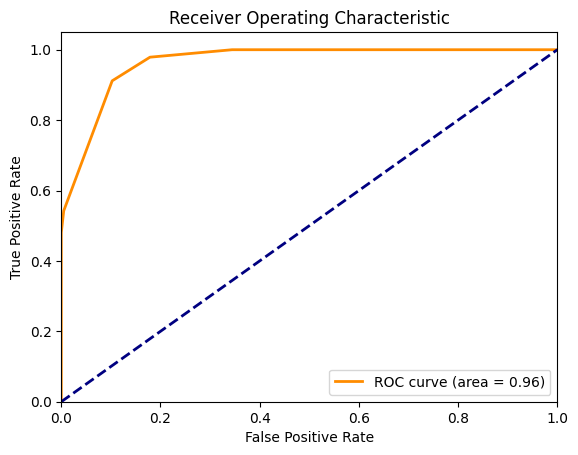

In [22]:

# y_probs: được truyền vào roc_curve để làm các giá trị thử cho threshold (có thêm giá trị inf)=> tìm ra các điểm (TPR, FPR)
# giá trị thresholds trả về chính là np.unique(y_probs) + 1 item là inf
# auc: hàm này là tính diện tích dưới đường ROC curve => (sum các hình thang dựa vào tọa độ của các điểm dữ liệu), nếu đữ liệu lớn nó có thể là tích phân 
fpr, tpr, thresholds = roc_curve(y_test, y_probs) 
roc_auc = auc(fpr, tpr) # giá trị roc_auc càng gần 1 càng tốt 

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Check ROC-AUC with RandomForestClassifier model

RandomForestClassifier model has a better value for ROC-AUC score

In [23]:
randomForest = RandomForestClassifier()
randomForest.fit(X_train, y_train)

y_pred_randomForest_pro = randomForest.predict_proba(X_test)[:, 1]
fpr_randomForest, tpr_randomForest, _ = roc_curve(y_test, y_pred_randomForest_pro)
roc_auc_randomForest = auc(fpr_randomForest, tpr_randomForest)

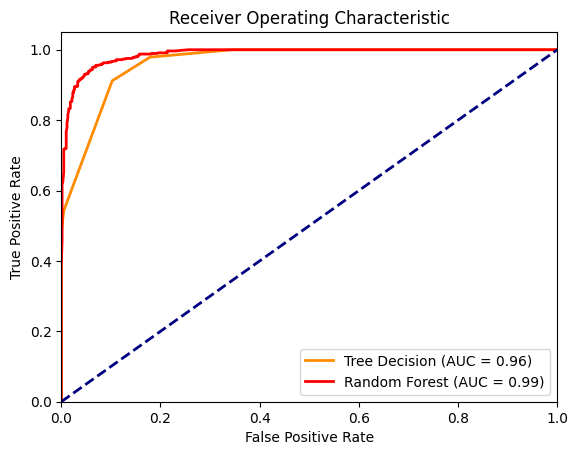

In [24]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Tree Decision (AUC = {roc_auc:.2f})')
plt.plot(fpr_randomForest, tpr_randomForest, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_randomForest:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 7.3 Cross validation

In [25]:
k = 10 
scores = cross_val_score(estimator=treemodel, X=X_test, y=y_test, cv=k, scoring='accuracy')
print("Accuracies from %d individual folds:" % k)
print(scores)
print("Accuracy calculated using %d-fold cross validation = %.3f" % (k, scores.mean()))

Accuracies from 10 individual folds:
[0.92307692 0.8974359  0.88888889 0.91452991 0.92307692 0.88034188
 0.8974359  0.88888889 0.85470085 0.8974359 ]
Accuracy calculated using 10-fold cross validation = 0.897


### 7.4 Important features 

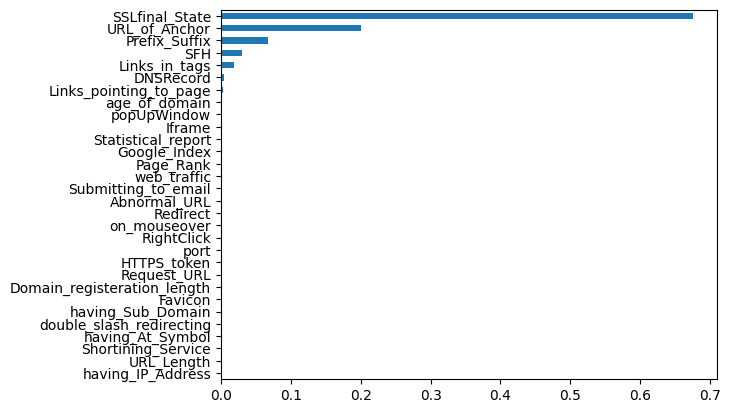

In [26]:
#treemodel = grid.best_estimator_.steps[-1][1]
importantFeatures = pd.Series(treemodel.feature_importances_, index=treemodel.feature_names_in_)
importantFeatures.sort_values(ascending=True).plot.barh()
plt.show()

### 8. Visualization

In [27]:
print(tree.export_text(treemodel,feature_names=feature_names, class_names=class_names))

|--- SSLfinal_State <= 0.50
|   |--- URL_of_Anchor <= -0.50
|   |   |--- class: Legitimate
|   |--- URL_of_Anchor >  -0.50
|   |   |--- Prefix_Suffix <= 0.00
|   |   |   |--- Links_in_tags <= -0.50
|   |   |   |   |--- class: Legitimate
|   |   |   |--- Links_in_tags >  -0.50
|   |   |   |   |--- class: Legitimate
|   |   |--- Prefix_Suffix >  0.00
|   |   |   |--- class: Phishing
|--- SSLfinal_State >  0.50
|   |--- URL_of_Anchor <= -0.50
|   |   |--- Prefix_Suffix <= 0.00
|   |   |   |--- Links_pointing_to_page <= -0.50
|   |   |   |   |--- class: Phishing
|   |   |   |--- Links_pointing_to_page >  -0.50
|   |   |   |   |--- class: Legitimate
|   |   |--- Prefix_Suffix >  0.00
|   |   |   |--- class: Phishing
|   |--- URL_of_Anchor >  -0.50
|   |   |--- SFH <= -0.50
|   |   |   |--- Prefix_Suffix <= 0.00
|   |   |   |   |--- class: Phishing
|   |   |   |--- Prefix_Suffix >  0.00
|   |   |   |   |--- class: Phishing
|   |   |--- SFH >  -0.50
|   |   |   |--- DNSRecord <= 0.00
|   |   

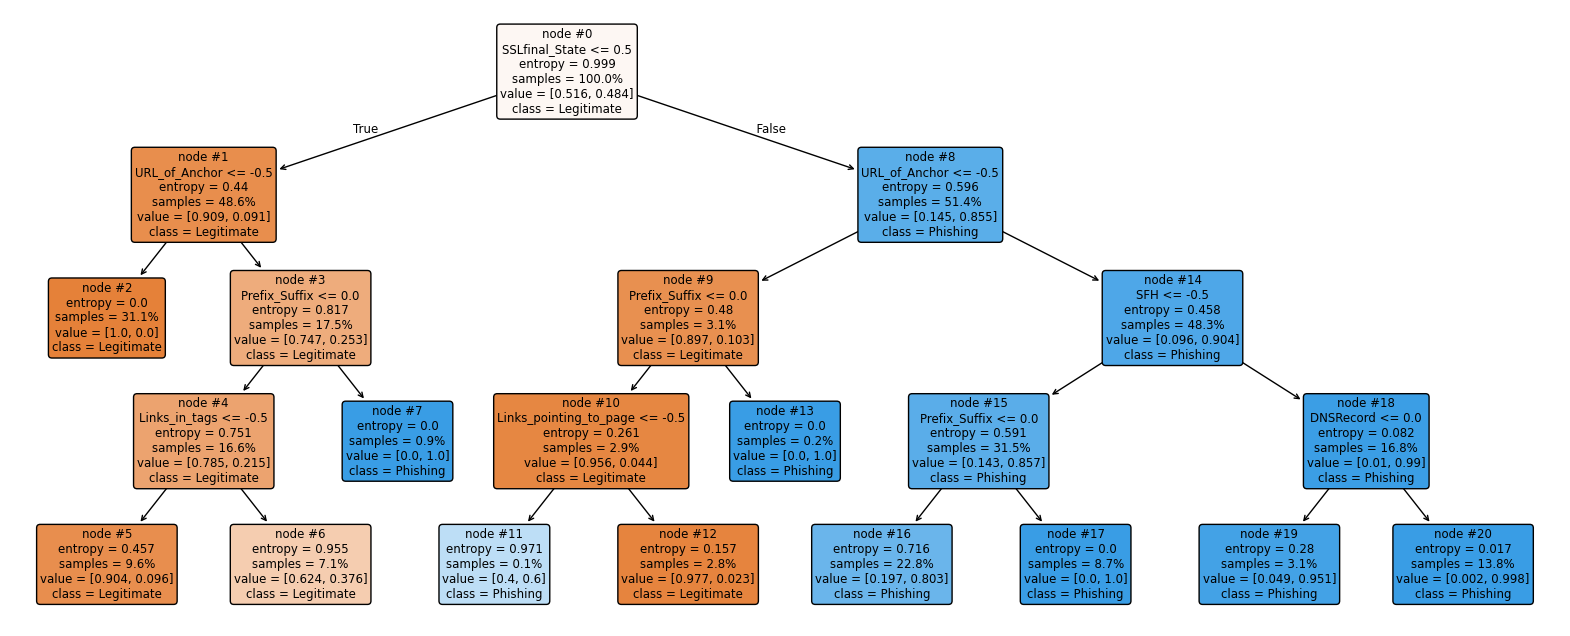

In [28]:
plt.figure(figsize=(20,8))
tree.plot_tree(treemodel,feature_names=feature_names, class_names=class_names,
            label='all', # label for gini value
            filled=True, 
            impurity=True, # gini
            node_ids=True, # node id
            proportion=True,
            rounded=True,
            precision=3,
            ax=None,
            fontsize=None
            )  
plt.show()


### 9. Conclusions:

Based on the analysis and the results obtained from the decision tree model, we can conclude that the top features for distinguishing phishing websites are:

- SSLfinal_State
- URL_of_Anchor
- Prefix_Suffix
 
To reduce the risk of falling victim to phishing pages, consider asking yourself the following questions when visiting a website:
- Does the site appear technically secure and use a valid HTTPS connection?
- Do most clickable links stay within the same domain, or do they redirect you elsewhere?
- Does the link contain prefixes or suffixes separated by (-) to the domain name?
<br><br>
If you answer “yes” to those questions, there is a high chance that the site is a phishing attempt.